In [13]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten, Concatenate, TimeDistributed, Conv2D, MaxPooling2D, Bidirectional
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import optuna
import os
import tensorflow as tf
from tensorflow.keras.layers import PReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']
        image_path = get_closest_image_path(timestamp, image_folder)
         
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
            doy_sin.append(doy_sin_value)
            doy_cos.append(doy_cos_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    # Convertir doy_sin y doy_cos a numpy arrays
    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    
    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es el valor GHI justo después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)


In [15]:
# Cargar datos y preparar el conjunto de entrenamiento
df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

# 1. Definir el rango de fechas para el entrenamiento
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'  # Fecha de inicio de entrenamiento
fecha_fin_entrenamiento = '2023-02-28 18:30:00'  # Fecha de fin de entrenamiento

# Filtrar el DataFrame por el rango de entrenamiento
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

# Cargar imágenes y valores GHI para el entrenamiento
image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train = load_images_and_ghi(df_entrenamiento, image_folder)

# Concatenar DOY sin y cos con las imágenes
X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train], axis=1)

# Crear las secuencias con time_steps = 6
time_steps = 12
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps)

Imagen no encontrada: None


[ WARN:0@26261.891] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None


[ WARN:0@26264.655] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@26267.407] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@26267.472] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None


[ WARN:0@26268.411] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@26270.170] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@26270.235] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


In [16]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization

# Modificar el modelo VGG16 + LSTM
def create_vgg16_lstm(de1, de2, a1, a2):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers[:10]:  # Congelar menos capas para permitir adaptación
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(de1, activation=a1))
    model.add(BatchNormalization())  # Añadir Batch Normalization
    model.add(Dense(de2, activation=a2))
    model.add(Flatten())
    return model

# Definir el modelo final con los mejores hiperparámetros
image_input = Input(shape=(time_steps, 64, 64, 3))
cnn = create_vgg16_lstm(256, 128, 'relu', 'relu')
time_distributed_cnn = TimeDistributed(cnn)(image_input)

lstm = Bidirectional(LSTM(76, return_sequences=False))(time_distributed_cnn)  # LSTM bidireccional

aux_input = Input(shape=(time_steps, 2))
aux_lstm = LSTM(32, return_sequences=False)(aux_input)

concatenated = Concatenate()([lstm, aux_lstm])
concatenated = Dense(125, activation='relu')(concatenated)
concatenated = BatchNormalization()(concatenated)
concatenated = Dense(36, activation='relu')(concatenated)
concatenated = Dropout(0.3)(concatenated)

dense_output = Dense(1, activation='linear')(concatenated)

model = Model(inputs=[image_input, aux_input], outputs=dense_output)
model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

# Entrenamiento del modelo final
model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=100, batch_size=32, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)])


Epoch 1/100


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_130', 'keras_tensor_175']. Received: the structure of inputs=('*', '*')
  warnings.warn(


121/121 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - loss: 0.5196 - mae: 0.5135 - val_loss: 0.2585 - val_mae: 0.4069 - learning_rate: 0.0010
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.0942 - mae: 0.2492 - val_loss: 0.1026 - val_mae: 0.2801 - learning_rate: 0.0010
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.0676 - mae: 0.2120 - val_loss: 0.0814 - val_mae: 0.2301 - learning_rate: 0.0010
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - loss: 0.0551 - mae: 0.1894 - val_loss: 0.1460 - val_mae: 0.3144 - learning_rate: 0.0010
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.0475 - mae: 0.1745 - val_loss: 0.1856 - val_mae: 0.3741 - learning_rate: 0.0010
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - loss: 0.0341 - mae: 0.1453 - val_loss: 0.0635 - val_mae: 0.2051 - learning_rate: 0.0010
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - loss: 0.0281 - mae: 0.1328 - val_loss: 0.1109 - val_mae: 0.2539 - learning_rate: 0.0010
Epoc

Imagen no encontrada: None


[ WARN:0@55140.678] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None
Imagen no encontrada: None


[ WARN:0@55141.118] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@55141.135] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@55141.135] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@55141.140] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 595ms/step
MAE en el conjunto de prueba: 0.22040988881351256
RMSE en el conjunto de prueba: 0.2755473137892977


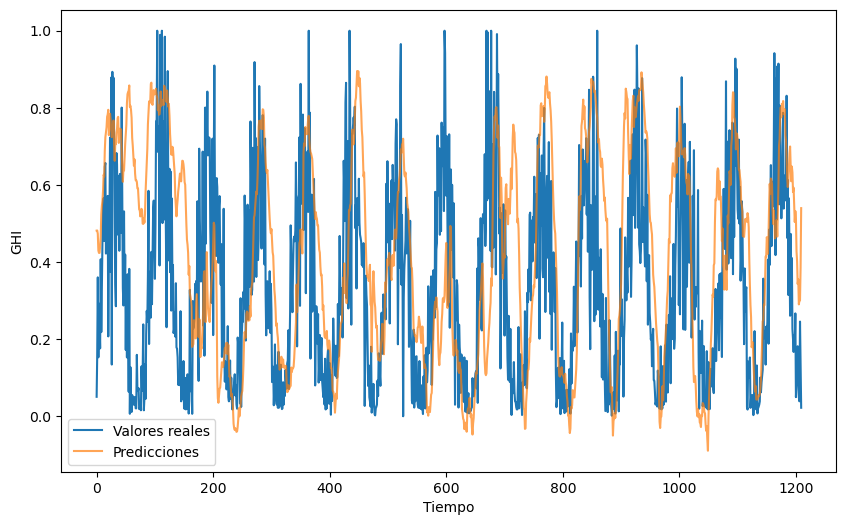

In [18]:

# Probar el modelo
# Preparar el conjunto de prueba
fecha_inicio_prueba = '2023-03-15 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-29 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test], axis=1)

# Crear las secuencias de prueba con time_steps = 6
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()